<a href="https://colab.research.google.com/github/nhdquyen/Traditional-ML-on-House-Price-Prediction/blob/main/House_Price_Prediction_Traditional_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Traditional Machine Learning on California House Price Prediction #

The content of this notebook is based on the book **Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow 2nd**, Chapter 2.
This dataset is based on data from 1990 California census.

## 1 - Frame the Problem

A Machine Learning pipeline for real estate investments

![](https://i.imgur.com/cgtQWuB.png)

> A sequence of data processing components is called a data pipeline. Pipelines are very common in Machine Learning systems, since there is a lot of data to manipulate and many data transformations to apply.
>
> Components typically run asynchronously. Each component pulls in a large amount of data, processes it, and spits out the result in another data store. Then, some time later, the next component in the pipeline pulls this data and spits out its own output. Each component is fairly self-contained: the interface between components is simply the data store. This makes the system simple to grasp (with the help of a data flow graph), and different teams can focus on different components. Moreover, if a component breaks down, the downstream components can often continue to run normally (at least for a while) by just using the last output from the broken component. This makes the architecture quite robust.
>
> On the other hand, a broken component can go unnoticed for some time if proper monitoring is not implemented. The data gets stale and the overall system’s performance drops.

### Select a Performance Measure (metric)

The next step is to select a performance measure. Because this is a regression problem, the metric we choose is **Root Mean Square Error (RMSE)**

## 2 - Get the Data

We could use our web browser to download the file and run tar xzf `housing.tgz` to decompress it and extract the CSV file, but it is preferable to create a small function to do that. Having a function that downloads the data is useful in particular if the data changes regularly: we can write a small script that uses the function to fetch the latest data (or set up a scheduled job to do that automatically at regular intervals). Automating the process of fetching the data is also useful if we need to install the dataset on multiple machines.

**Import data and libraries**

In [18]:
# Import libaries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)  
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

fetch_housing_data()
housing = load_housing_data()

housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [ ]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [ ]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [ ]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


**First Overview:**

* Each value represents  one district.
* There are ten attributes.
* `total_bedrooms` has only 20.433 nonnull values, meaning that 207 districts are missing this feature.
* All attributes are numerical, except the `ocean_proximity` field.

Next let's take a look at a histogram for each numerical attribute.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd666c27550>,
      dtype=object)

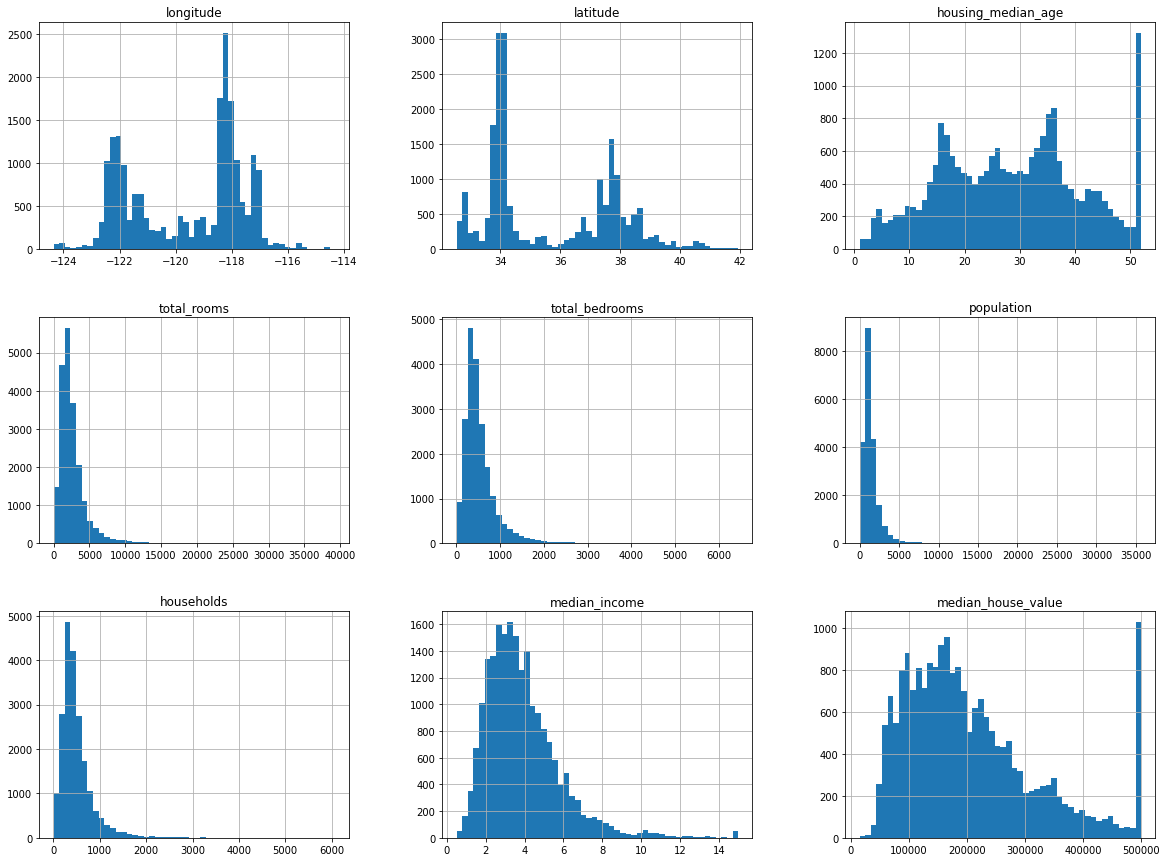

In [ ]:
housing.hist(bins=50, figsize=(20,15))

**Notes:**

* Median Income attribute is expressed in 10,000USD
* Data is capped in Median House Value and Housing Median Age
* Attributes are at different scales: tens, thousands, hundreds of thousands...
* Note: Many histogram are tail-heavy (skewness). This may make it harder for some ML algorithms to detect patterns. We will try transforming these attributes to have more bell-shaped distributions.

Let's take a look at the correlation

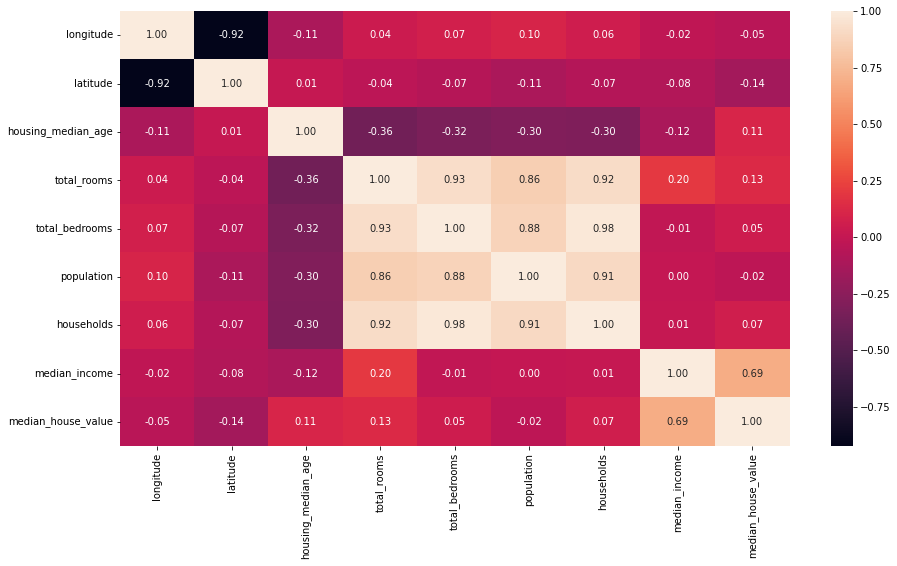

In [ ]:
# Get the correlation matrix of dataframe
plt.figure(figsize = (15,8))
sns.heatmap(housing.corr(),
            annot = True,
            fmt = '.2f')

### Create a Test Set to evaluate models' accuracy later

We can use `sklearn.train_test_split` to have a random sampling

In [19]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

But it's not perfect. We might run the risk of introducing a significant sampling-bias. When a survey company decides to call 1,000 people to ask them a few questions, they don’t just pick 1,000 people randomly in a phone book. They try to ensure that these 1,000 people are representative of the whole population. For example, the US population is 51.3% females and 48.7% males, so a well-conducted survey in the US would try to maintain this ratio in the sample: 513 female and 487 male. This is called stratified sampling: the population is divided into homogeneous subgroups called strata, and the right number of instances are sampled from each stratum to guarantee that the test set is representative of the overall population.

We know that median income is a very important attribute to predict median housing prices. You may want to ensure that the test set is representative of the various categories of incomes in the whole dataset.

In [20]:
# create new column 'income_cat'
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])
housing.sort_values('income_cat', ascending = False)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,5
9313,-122.51,37.98,37.0,4801.0,699.0,1830.0,679.0,6.0762,487800.0,NEAR BAY,5
9316,-122.46,37.98,10.0,1325.0,189.0,427.0,162.0,12.0933,500001.0,NEAR BAY,5
9317,-122.49,37.99,27.0,5470.0,755.0,1916.0,764.0,6.9940,420800.0,NEAR BAY,5
9318,-122.49,37.98,34.0,1256.0,178.0,460.0,174.0,6.4271,451700.0,NEAR BAY,5
...,...,...,...,...,...,...,...,...,...,...,...
2046,-119.72,36.73,9.0,1914.0,491.0,1116.0,424.0,1.4646,65900.0,INLAND,1
2048,-119.73,36.72,26.0,2645.0,1005.0,1660.0,991.0,0.6991,89500.0,INLAND,1
15819,-122.42,37.76,46.0,2150.0,817.0,2075.0,807.0,1.3824,212500.0,NEAR BAY,1
19692,-121.61,39.13,33.0,2559.0,539.0,1583.0,504.0,1.4727,53000.0,INLAND,1


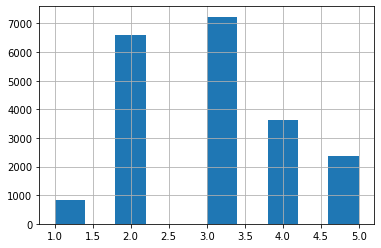

In [ ]:
housing["income_cat"].hist()

In [ ]:
housing["income_cat"].value_counts(normalize=True)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

In [21]:
# split train & test set with stratifying income cat
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42, stratify=housing['income_cat'])
train_set["income_cat"].value_counts(normalize = True)

3    0.350594
2    0.318859
4    0.176296
5    0.114462
1    0.039789
Name: income_cat, dtype: float64

In [22]:
# drop columns
train_set = train_set.drop("income_cat", axis=1)
test_set = test_set.drop("income_cat", axis=1)

## 3 - Exploring and Visualize Data to Gain Insights

First, make sure the test set is put aside and only explore the training set. Let's create a copy so that we can play with the training set without harming it:

In [23]:
# put the test set aside and only explores the training set
housing = train_set.copy()

### Visualize Geographical Data

In [ ]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Saving figure housing_prices_scatterplot


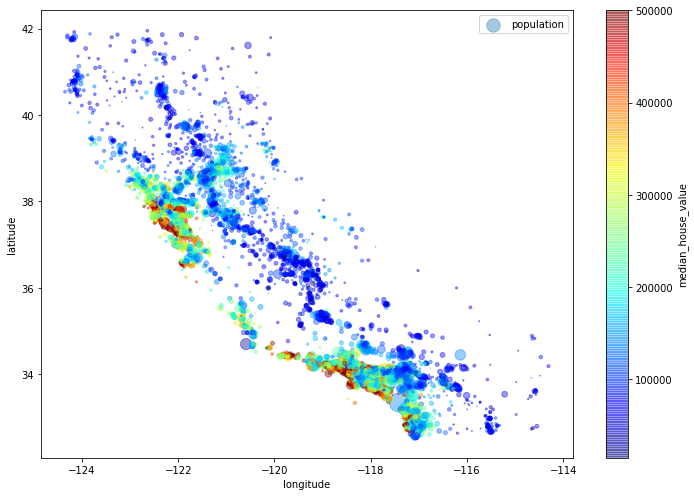

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()
save_fig("housing_prices_scatterplot")

In [ ]:
PROJECT_ROOT_DIR

'.'

In [ ]:
# Download the California image
images_path = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "california.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/end_to_end_project/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('./images/california.png', <http.client.HTTPMessage at 0x7f4e41f5d450>)

Saving figure california_housing_prices_plot


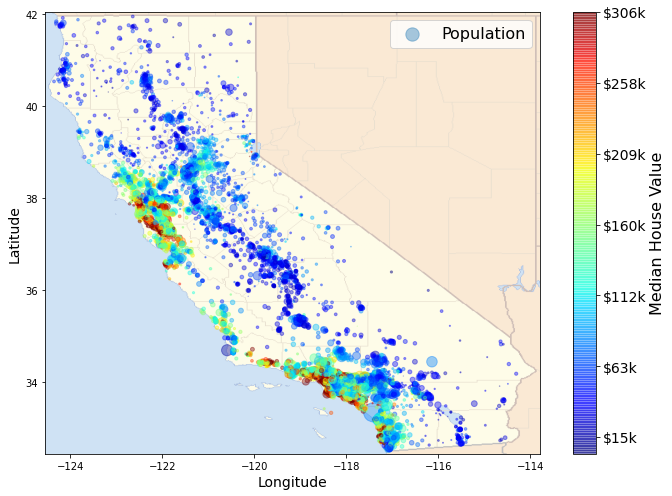

In [ ]:
import matplotlib.image as mpimg
california_img = mpimg.imread(os.path.join(images_path, filename))
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=housing['population']/100, label="Population",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
save_fig("california_housing_prices_plot")
plt.show()

### Looking for Correlations: The correlation coefficient only measures linear correlations. It may completely miss out on nonlinear relationships.

In [ ]:
corr_matrix = housing.corr()
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924478,-0.105823,0.048909,0.076686,0.108071,0.063146,-0.019615,-0.047466
latitude,-0.924478,1.000000,0.005737,-0.039245,-0.072550,-0.115290,-0.077765,-0.075146,-0.142673
housing_median_age,-0.105823,0.005737,1.000000,-0.364535,-0.325101,-0.298737,-0.306473,-0.111315,0.114146
total_rooms,0.048909,-0.039245,-0.364535,1.000000,0.929391,0.855103,0.918396,0.200133,0.135140
total_bedrooms,0.076686,-0.072550,-0.325101,0.929391,1.000000,0.876324,0.980167,-0.009643,0.047781
population,0.108071,-0.115290,-0.298737,0.855103,0.876324,1.000000,0.904639,0.002421,-0.026882
households,0.063146,-0.077765,-0.306473,0.918396,0.980167,0.904639,1.000000,0.010869,0.064590
median_income,-0.019615,-0.075146,-0.111315,0.200133,-0.009643,0.002421,0.010869,1.000000,0.687151
median_house_value,-0.047466,-0.142673,0.114146,0.135140,0.047781,-0.026882,0.064590,0.687151,1.000000


Another way to check for correlation between attributes is to use the pandas scatter_matrix() function, which plots every numerical attribute against every other numerical attribute. Since there are now 11 numerical attributes, you would get 112 = 121 plots, which would not fit on a page—so let’s just focus on a few promising attributes that seem most correlated with the median housing value

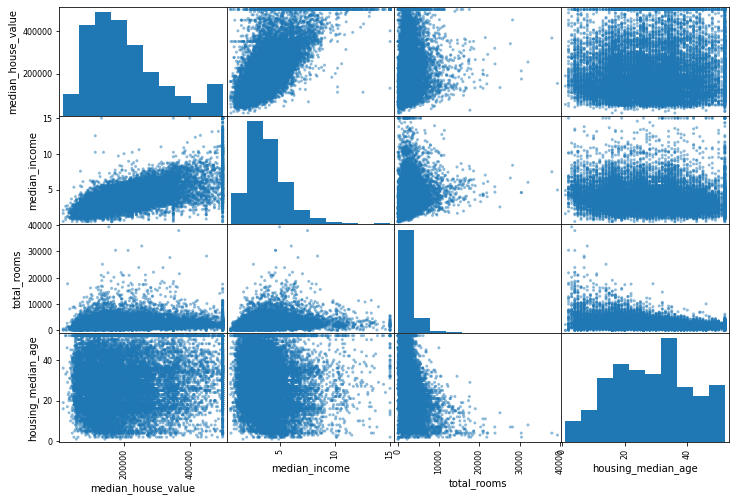

In [ ]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

plt.show()

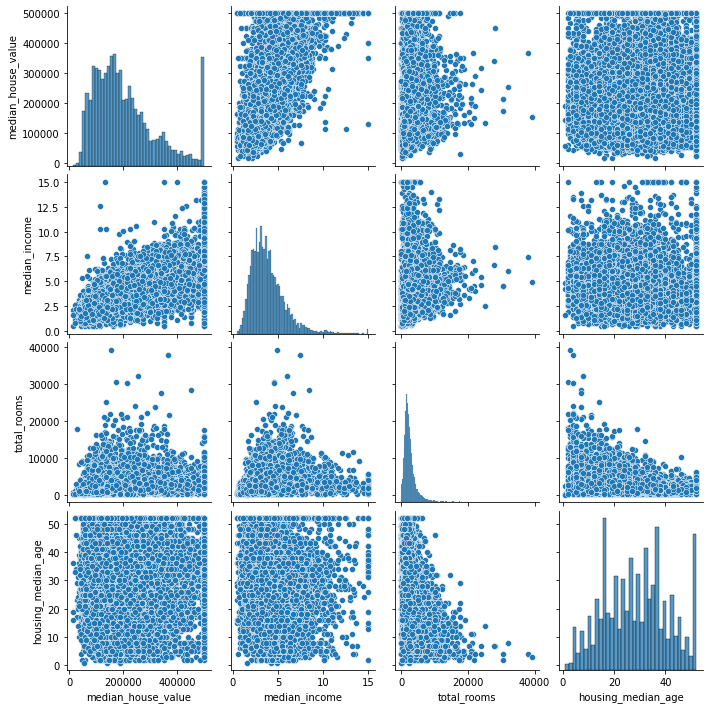

In [ ]:
# seaborn also has a similiar function for this plot
sns.pairplot(housing[attributes])

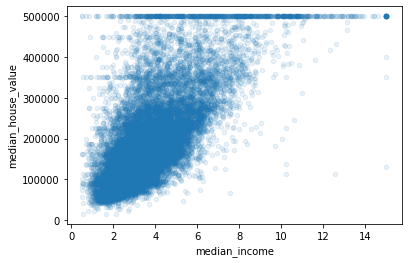

In [ ]:
# From all above correlation matrix and graphs, the most promising attribute to predict the median house value is the median income
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)

**This plot reveals a few things:**
* The correlation of 2 observed variables is strong. (0.67)
* The price cap is clearly visible as a horizontal line at $500,000

* But this plot reveals other less obvious straight lines: a horizontal line around 450,000, another around 350,000

### Experimenting with Attribute Combinations

There are a few things we could try manipulating the data before training ML algorithms. Example, the number of rooms in a district is not very useful. What we really want is the number of rooms per household. Similiar with the total number of bedrooms, we probably want to compare it to the number of rooms. And the population per household also seems like an interesting attribute combination to look at.

In [24]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,72100.0,INLAND,5.485836,0.205784,3.168555
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,279600.0,NEAR OCEAN,6.927083,0.160714,2.623698
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,82700.0,INLAND,5.393333,0.191595,2.223333
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,112500.0,NEAR OCEAN,3.886128,0.276505,1.859213
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,238300.0,<1H OCEAN,6.096552,0.182692,3.167241
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15174,-117.07,33.03,14.0,6665.0,1231.0,2026.0,1001.0,5.0900,268500.0,<1H OCEAN,6.658342,0.184696,2.023976
12661,-121.42,38.51,15.0,7901.0,1422.0,4769.0,1418.0,2.8139,90400.0,INLAND,5.571932,0.179977,3.363188
19263,-122.72,38.44,48.0,707.0,166.0,458.0,172.0,3.1797,140400.0,<1H OCEAN,4.110465,0.234795,2.662791
19140,-122.70,38.31,14.0,3155.0,580.0,1208.0,501.0,4.1964,258100.0,<1H OCEAN,6.297405,0.183835,2.411178


In [25]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

Not bad! The new bedrooms_per_room attribute is much more correlated with the median house value than the total number of rooms or bedrooms. Apparently houses with a **lower** bedroom/room ratio tend to have higher value (notice the negative sign). The number of rooms per household is also more informative than the total number of rooms in a district — obviously the larger the houses, the higher price they are at.

> This round of exploration does not have to be absolutely thorough; the point is to start off on the right foot and quickly gain insights that will help us get a first reasonably good prototype. But this is an iterative process: once a prototype is up and running, we can analyze its output to gain more insights and come back to this exploration step.

## 4 - Prepare the Data for ML algorithms

It’s time to prepare the data for your Machine Learning algorithms. Instead of doing this manually, you should write functions for this purpose.

In [26]:
housing = train_set.drop("median_house_value", axis=1) 
housing_labels = train_set["median_house_value"].copy() 

### Data Cleaning

We saw earlier that the total_bedrooms attribute has some missing values, so let’s fix this. We have 3 options:

```python
housing.dropna(subset=["total_bedrooms"])    # option 1
housing.drop("total_bedrooms", axis=1)       # option 2
median = housing["total_bedrooms"].median()  # option 3
housing["total_bedrooms"].fillna(median, inplace=True)
```

Here we choose option 3, we should compute the median value on the training set and use it to fill the missing values in the training set. 

> Make sure we save the median value computed. We will need it later to replace missing values in the test set when we want to evaluate your system, and also once the system goes live to replace missing values in new data.

Scikit-Learn provides a handy class to take care of missing values: `SimpleImputer`. First, create a SimpleImputer instance, specifying that we want to replace each attribute’s missing values with the median of that attribute:

In [27]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

# the median can only be computed on numerical attributes
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)

print(imputer.statistics_)
print(housing_num.median().values)

[-118.51      34.26      29.      2119.       433.      1164.
  408.         3.54155]
[-118.51      34.26      29.      2119.       433.      1164.
  408.         3.54155]


Now we can use this “trained” imputer to transform the training set by replacing missing values with the learned medians:

In [28]:
X = imputer.transform(housing_num)

# The result is a plain NumPy array containing the transformed features. 
# If you want to put it back into a pandas DataFrame:
pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964
...,...,...,...,...,...,...,...,...
15174,-117.07,33.03,14.0,6665.0,1231.0,2026.0,1001.0,5.0900
12661,-121.42,38.51,15.0,7901.0,1422.0,4769.0,1418.0,2.8139
19263,-122.72,38.44,48.0,707.0,166.0,458.0,172.0,3.1797
19140,-122.70,38.31,14.0,3155.0,580.0,1208.0,501.0,4.1964


### Handling Categorical Attributes


In [ ]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     7277
INLAND        5262
NEAR OCEAN    2124
NEAR BAY      1847
ISLAND           2
Name: ocean_proximity, dtype: int64

In [29]:
from sklearn.preprocessing import OrdinalEncoder

housing_cat = housing[["ocean_proximity"]] # [column] returns series, [[column]] returns dataframe
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

print(housing_cat[:10])
print(housing_cat_encoded[:10])
print(f"Encoder's categories {ordinal_encoder.categories_}")

      ocean_proximity
12655          INLAND
15502      NEAR OCEAN
2908           INLAND
14053      NEAR OCEAN
20496       <1H OCEAN
1481         NEAR BAY
18125       <1H OCEAN
5830        <1H OCEAN
17989       <1H OCEAN
4861        <1H OCEAN
[[1.]
 [4.]
 [1.]
 [4.]
 [0.]
 [3.]
 [0.]
 [0.]
 [0.]
 [0.]]
Encoder's categories [array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)]


In [30]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

> Notice that the output is a SciPy sparse matrix, instead of a NumPy array. This is very useful when there are categorical attributes with thousands of categories. After one-hot encoding, we get a matrix with thousands of columns, and the matrix is full of 0s except for a single 1 per row. Using up tons of memory mostly to store zeros would be very wasteful, so instead a sparse matrix only stores the location of the nonzero elements. We can use it mostly like a normal 2D array, to convert it to a (dense) NumPy array, call the toarray() method:

In [ ]:
housing_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [31]:
cat_encoder.categories_ # after .fit 

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

### Custom Transformer

Although Scikit-Learn provides many useful transformers, we can also write our own for tasks such as custom cleanup operations or combining specific attributes.


In [32]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
        
        # concatenate newly created columns to the existing numpy array X
        return np.c_[X, rooms_per_household, population_per_household,
                      bedrooms_per_room]

attr_adder = CombinedAttributesAdder()
housing_extra_attribs = attr_adder.transform(housing.values)

In [ ]:
housing_extra_attribs[0]

array([-121.46, 38.52, 29.0, 3873.0, 797.0, 2237.0, 706.0, 2.1736,
       'INLAND', 5.485835694050992, 3.168555240793201,
       0.20578363026077975], dtype=object)

In [33]:
housing_extra_attribs.shape

(16512, 12)

In [34]:
housing.shape

(16512, 9)

### Importance: FEARTURE SCAILING

One of the most important transformations is feature scaling. Most Machine Learning algorithms don’t perform well when the input numerical attributes are at very different scales.

There are two common ways to get all attributes to have the same scale: `min-max scaling`(normalization) and `standardization`.

* Min-Max-Scaling: values are shifted so that they end up ranging [0,1] or [-1,1]. Scikit-learn provides a transformer called `MinMaxScaler` for this.
* Standardization: first it subtracts the mean value (so standardized values always have a zero mean), and then it divides by the standard deviation so that the resulting distribution has unit variance. Standardization does not bound values to a specific range, and is much less affected by outliers. Scikit-learn provides a transformer called `StandardScaler` for this.

### Transformation Pipeline

There are many data transformation steps that need to be executed in the right order. Fortunately, Scikit-Learn provides the Pipeline class to help with such sequences of transformations. Here is a small pipeline for the numerical attributes:

In [35]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

So far, we have handled the categorical columns and the numerical columns separately. It would be more convenient to have a single transformer able to handle all columns, applying the appropriate transformations to each column.

In [ ]:
housing_num

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964
...,...,...,...,...,...,...,...,...
15174,-117.07,33.03,14.0,6665.0,1231.0,2026.0,1001.0,5.0900
12661,-121.42,38.51,15.0,7901.0,1422.0,4769.0,1418.0,2.8139
19263,-122.72,38.44,48.0,707.0,166.0,458.0,172.0,3.1797
19140,-122.70,38.31,14.0,3155.0,580.0,1208.0,501.0,4.1964


In [159]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [37]:
full_pipeline.named_transformers_['cat'].categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

## 5 - Select and Train a Model

Now using `housing_prepared` and `housing_labels` to train model with **Root Mean Squared Error** as our metric

### Using LinearRegression

In [ ]:
# Linear Regression is often chosen as base line estimator 
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error as mse
model = LinearRegression()
model.fit(housing_prepared, housing_labels)
housing_pred = model.predict(housing_prepared)
rmse = mse(housing_labels, housing_pred)**.5
rmse

68627.87390018745

### Using DecisionTreeRegressor

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Decision Tree will overfit without tuning - everytime. As the model will keep spliting up until there is one instance per branch/leaf. 
# This explains why MSE here is 0
model2 = DecisionTreeClassifier()
model2.fit(housing_prepared, housing_labels)
housing_pred2 = model2.predict(housing_prepared)
mse(housing_labels, housing_pred2)

0.0

In [ ]:
# Decision Tree model returns weights indicating feature importances 
# But in this case, it's meaningless if the model isn't best optimized with randomnization and tunning. We will get back to this later on.
model2.feature_importances_ 

array([0.09036831, 0.08543874, 0.08682425, 0.0819458 , 0.07526588,
       0.08213885, 0.07724199, 0.11335378, 0.08880708, 0.09632311,
       0.0859334 , 0.01326468, 0.00323715, 0.        , 0.00870879,
       0.01114819])

In [ ]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
full_features_tfmed = num_attribs + extra_attribs + list(full_pipeline.named_transformers_['cat'].categories_[0])
np.array(full_features_tfmed)

array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'rooms_per_hhold', 'pop_per_hhold', 'bedrooms_per_room',
       '<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype='<U18')

In [ ]:
pd.DataFrame({'features': full_features_tfmed, 'importances': model2.feature_importances_}).sort_values('importances')

,features,importances
13,ISLAND,0.000000
12,INLAND,0.003237
14,NEAR BAY,0.008709
15,NEAR OCEAN,0.011148
11,<1H OCEAN,0.013265
4,total_bedrooms,0.075266
6,households,0.077242
3,total_rooms,0.081946
5,population,0.082139
1,latitude,0.085439


### Better Evaluation Using Cross-Validation

One way to evaluate the Decision Tree model would be to use the train_test_split() function to split the training set into a smaller training set and a validation set, then train chosen models against the smaller training set and evaluate them against the validation set. It’s a bit of work, but nothing too difficult, and it would work fairly well.

A great alternative is to use Scikit-Learn’s K-fold cross-validation feature. The following code randomly splits the training set into n = 5 distinct subsets called folds, then it trains and evaluates the Decision Tree model 5 times, picking a different fold for evaluation every time and training on the other 4 folds. The result is an array containing the 5 evaluation scores:

In [ ]:
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score

model2 = DecisionTreeClassifier()
KFold = KFold(n_splits = 5, 
              shuffle = True,
              random_state = 11)

scores = -cross_val_score(model2, housing_prepared, housing_labels, scoring = 'neg_mean_squared_error', cv = KFold).astype(int)
np.sort(scores)**.5 # array of mse scores from 10 evaluations sorted

array([80546.28753704, 82169.33237528, 82479.62742399, 82883.57114652,
       84222.44125529])

In [ ]:
# Average RSME for Decision Tree Regressor with 10 kfold
decision_tree_mean_score = np.mean(np.sort(scores)**.5)
decision_tree_mean_score

82460.25194762406

***Let's try some Machine Learning Regressors with cross validation to have an over view of each model's performance before tuning.***




### Linear Regression with Regularization: Ridge, Lasso and Elastic Net

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

In [ ]:
# chose kfold with 5 splits
KFold = KFold(n_splits = 5, 
              shuffle = True,
              random_state = 42)

In [ ]:
ridge_scores = cross_val_score(Ridge(),
                         housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error",
                         cv = KFold)

ridge_mean_score = np.mean((-ridge_scores)**.5)
print(f'The average RMSE for Ridge Regression is {ridge_mean_score: .2f}')

The average RMSE for Ridge Regression is  69047.27


In [ ]:
lasso_scores = cross_val_score(Lasso(),
                         housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error",
                         cv = KFold)

lasso_mean_score = np.mean((-lasso_scores)**.5)
print(f'The average RMSE for Lasso Regression is {lasso_mean_score: .2f}')

The average RMSE for Lasso Regression is  69047.60


In [ ]:
elastic_scores = cross_val_score(ElasticNet(),
                         housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error",
                         cv = KFold)

elastic_mean_score = np.mean((-elastic_scores)**.5)
print(f'The average RMSE for Elastic Net Regression is {elastic_mean_score: .2f}')

The average RMSE for Elastic Net Regression is  78681.72


### Support Vector Regression

In [ ]:
from sklearn.svm import SVR

SVM_scores = cross_val_score(SVR(),
                         housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error",
                         cv = KFold)

SVM_mean_score = np.mean((-SVM_scores)**.5)
print(f'The average RMSE for SVM Regression is {SVM_mean_score: .2f}')

The average RMSE for SVM Regression is  118632.29


### K Neighbor Regression

In [ ]:
from sklearn.neighbors import KNeighborsRegressor as KNR

KNR_scores = cross_val_score(KNR(),
                         housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error",
                         cv = KFold)

KNR_mean_score = np.mean((-KNR_scores)**.5)
print(f'The average RMSE for KNR Regression is {KNR_mean_score: .2f}')

The average RMSE for KNR Regression is  62705.83


### Random Forest Regression


In [ ]:
from sklearn.ensemble import RandomForestRegressor as RFR

RFR_scores = cross_val_score(RFR(),
                         housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error",
                         cv = KFold)

RFR_mean_score = np.mean((-RFR_scores)**.5)
print(f'The average RMSE for RFR Regression is {RFR_mean_score: .2f}')

The average RMSE for RFR Regression is  50658.29


### Gradient Boost, Adaptive Boost Regression

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.ensemble import AdaBoostRegressor as ABR

GBR_scores = cross_val_score(GBR(),
                         housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error",
                         cv = KFold)

GBR_mean_score = np.mean((-GBR_scores)**.5)
print(f'The average RMSE for GBR Regression is {GBR_mean_score: .2f}')

The average RMSE for GBR Regression is  53211.95


In [ ]:
ABR_scores = cross_val_score(ABR(),
                         housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error",
                         cv = KFold)

ABR_mean_score = np.mean((-ABR_scores)**.5)
print(f'The average RMSE for ABR Regression is {ABR_mean_score: .2f}')

The average RMSE for ABR Regression is  82877.46


### XGBoost, Light GBM

In [ ]:
!pip install lightgbm

In [ ]:
from xgboost import XGBRegressor as XGB

XGB_scores = cross_val_score(XGB(),
                         housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error",
                         cv = KFold)

XGB_mean_score = np.mean((-XGB_scores)**.5)
print(f'The average RMSE for XGB Regression is {XGB_mean_score: .2f}')

[09:03:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:03:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:03:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:03:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:03:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
The average RMSE for XGB Regression is  53228.76


In [ ]:
from lightgbm import LGBMRegressor as LGBM

LGBM_scores = cross_val_score(LGBM(),
                         housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error",
                         cv = KFold)

LGBM_mean_score = np.mean((-LGBM_scores)**.5)
print(f'The average RMSE for LGBM Regression is {LGBM_mean_score: .2f}')

The average RMSE for LGBM Regression is  46755.58


In [ ]:
# Organize average RMSE's into dataframe
rsme = {}
rsme['decision_tree'] = decision_tree_mean_score
rsme['linear_ridge'] = ridge_mean_score 
rsme['linear_lasso'] = lasso_mean_score
rsme['elastic_net'] = elastic_mean_score
rsme['support_vector_machine'] = SVM_mean_score
rsme['k_nearest_neighbors'] = KNR_mean_score
rsme['random_forest'] = RFR_mean_score
rsme['gradient_boost'] = GBR_mean_score
rsme['ADAboost'] = ABR_mean_score
rsme['XGBoost'] = XGB_mean_score
rsme['LightGBM'] = LGBM_mean_score

rsme_df = pd.DataFrame.from_dict(rsme, orient = 'index', columns = ['Average RMSE'])
rsme_df.sort_values('Average RMSE', inplace = True)
rsme_df

,Average RMSE
LightGBM,46755.578296
random_forest,50658.288746
gradient_boost,53211.951619
XGBoost,53228.755882
k_nearest_neighbors,62705.830086
linear_ridge,69047.265765
linear_lasso,69047.595256
elastic_net,78681.721849
decision_tree,82460.251948
ADAboost,82877.456075


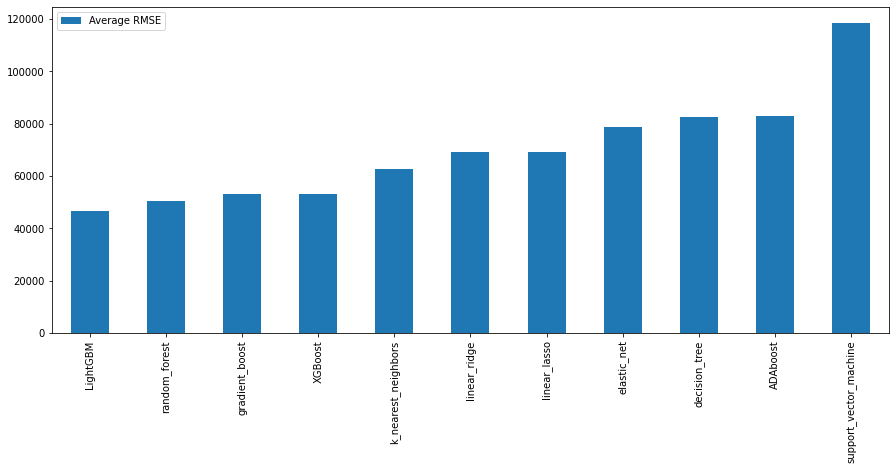

In [106]:
rsme_df.plot(kind = 'bar', figsize = (15,6))

**Next step: we pick top 5 models with lowest RMSE for fine tuning to optimize accuracy.**

We should save every model we experiment with so that we can come back easily to any model you want. Make sure we save both the hyperparameters and the trained parameters, as well as the cross-validation scores and perhaps the actual predictions as well. This will allow us to easily compare scores across model types, and compare the types of errors they make. We can easily save Scikit-Learn models by using Python’s pickle module or by using the joblib library, which is more efficient at serializing large NumPy arrays (install this library using pip):

In [ ]:
import joblib

joblib.dump(forest_reg, "my_model.pkl")
# and later...
my_model_loaded = joblib.load("my_model.pkl")

## 6 - Grid Search and Randomized Search for Cross Validation

### Grid Search

One option would be to fiddle with the hyperparameters manually, until you find a great combination of hyperparameter values. This would be very tedious work, and you may not have time to explore many combinations.

Instead, you should get Scikit-Learn’s GridSearchCV to search for you. All you need to do is tell it which hyperparameters you want it to experiment with and what values to try out, and it will use cross-validation to evaluate all the possible combinations of hyperparameter values. 

In [39]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor as RFR
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}]

model = RFR(bootstrap=False)

grid_search = GridSearchCV(model, param_grid, cv = 5,
                           scoring='neg_mean_squared_error',
                           return_train_score = True, verbose = True) 

grid_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(bootstrap=False),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]}],
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=True)

In [ ]:
# best parameter from grid search results
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [ ]:
RFR(**grid_search.best_params_)

RandomForestRegressor(max_features=6, n_estimators=30)

In [43]:
best_RFR = grid_search.best_estimator_
best_RFR

RandomForestRegressor(bootstrap=False, max_features=6, n_estimators=30)

In [40]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print('rmse:', np.sqrt(-mean_score), params)

rmse: 61936.19734861882 {'max_features': 2, 'n_estimators': 3}
rmse: 54317.96546707401 {'max_features': 2, 'n_estimators': 10}
rmse: 51463.29489914259 {'max_features': 2, 'n_estimators': 30}
rmse: 59182.69850901444 {'max_features': 4, 'n_estimators': 3}
rmse: 51797.46630940544 {'max_features': 4, 'n_estimators': 10}
rmse: 49716.71261754545 {'max_features': 4, 'n_estimators': 30}
rmse: 56375.9950287656 {'max_features': 6, 'n_estimators': 3}
rmse: 50858.834717060025 {'max_features': 6, 'n_estimators': 10}
rmse: 49045.10810261986 {'max_features': 6, 'n_estimators': 30}
rmse: 57478.86272806358 {'max_features': 8, 'n_estimators': 3}
rmse: 50857.593689902315 {'max_features': 8, 'n_estimators': 10}
rmse: 49414.33089238382 {'max_features': 8, 'n_estimators': 30}


In [41]:
pd.DataFrame(cvres)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.116863,0.004832,0.006981,0.000459,2,3,"{'max_features': 2, 'n_estimators': 3}",-3.546145e+09,-3.647065e+09,-3.624634e+09,-4.114129e+09,-4.248491e+09,-3.836093e+09,2.870165e+08,12,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000
1,0.385738,0.005396,0.019646,0.000860,2,10,"{'max_features': 2, 'n_estimators': 10}",-2.895918e+09,-2.789813e+09,-2.975894e+09,-3.007095e+09,-3.083486e+09,-2.950441e+09,1.003321e+08,8,-0.000000,-0.000000,-71.476154,-0.000000,-0.000000,-14.295231,28.590462
2,1.131095,0.016289,0.053127,0.001128,2,30,"{'max_features': 2, 'n_estimators': 30}",-2.653685e+09,-2.496108e+09,-2.591401e+09,-2.746546e+09,-2.754613e+09,-2.648471e+09,9.734840e+07,6,-53.221289,-2.754015,-7.778619,-0.903356,-26.284801,-18.188416,19.688634
3,0.193761,0.002822,0.007230,0.000552,4,3,"{'max_features': 4, 'n_estimators': 3}",-3.651165e+09,-3.366229e+09,-3.430199e+09,-3.502725e+09,-3.562640e+09,-3.502592e+09,9.951419e+07,11,-0.000000,-4.205887,-0.000000,-0.000000,-0.000000,-0.841177,1.682355
4,0.622114,0.005273,0.018836,0.000473,4,10,"{'max_features': 4, 'n_estimators': 10}",-2.804899e+09,-2.622868e+09,-2.640312e+09,-2.739063e+09,-2.607746e+09,-2.682978e+09,7.629384e+07,7,-0.000000,-0.000000,-0.242241,-0.000000,-0.000000,-0.048448,0.096896
5,1.871642,0.016063,0.052033,0.001249,4,30,"{'max_features': 4, 'n_estimators': 30}",-2.559336e+09,-2.356155e+09,-2.418791e+09,-2.508921e+09,-2.515555e+09,-2.471752e+09,7.367326e+07,3,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000
6,0.262529,0.003431,0.006749,0.000128,6,3,"{'max_features': 6, 'n_estimators': 3}",-3.432820e+09,-3.129959e+09,-3.000448e+09,-3.020000e+09,-3.308037e+09,-3.178253e+09,1.677136e+08,9,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000
7,0.875078,0.009971,0.018267,0.000138,6,10,"{'max_features': 6, 'n_estimators': 10}",-2.560403e+09,-2.528344e+09,-2.501037e+09,-2.626820e+09,-2.716502e+09,-2.586621e+09,7.732168e+07,5,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000
8,2.632566,0.008515,0.051941,0.000931,6,30,"{'max_features': 6, 'n_estimators': 30}",-2.433348e+09,-2.295245e+09,-2.254447e+09,-2.530149e+09,-2.513924e+09,-2.405423e+09,1.122868e+08,1,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000
9,0.344519,0.004362,0.007002,0.000265,8,3,"{'max_features': 8, 'n_estimators': 3}",-3.191640e+09,-3.251517e+09,-3.465972e+09,-3.270993e+09,-3.338976e+09,-3.303820e+09,9.373003e+07,10,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000


### Analyze the best models and their errors

You will often gain good insights on the problem by inspecting the best models. For example, the RandomForestRegressor can indicate the relative importance of each attribute for making accurate predictions:

In [44]:
feature_importances = best_RFR.feature_importances_
feature_importances

array([7.73918375e-02, 6.88498982e-02, 4.22941400e-02, 1.67902122e-02,
       1.60764499e-02, 1.62485386e-02, 1.61539323e-02, 3.37650492e-01,
       5.22189446e-02, 1.06713683e-01, 9.05931055e-02, 1.32327159e-02,
       1.37726422e-01, 5.28363814e-05, 3.46175022e-03, 4.54504186e-03])

As mentioned at Decision Tree model, here is a way to extract full column names that goes along with `feature_importances`

In [45]:
full_pipeline.named_transformers_

{'cat': OneHotEncoder(),
 'num': Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                 ('attribs_adder', CombinedAttributesAdder()),
                 ('std_scaler', StandardScaler())])}

In [46]:
list(full_pipeline.named_transformers_['cat'].categories_[0]) # list() to turn an array to list

['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN']

In [47]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_one_hot_attribs = list(full_pipeline.named_transformers_["cat"].categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs 
print(attributes)

['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'rooms_per_hhold', 'pop_per_hhold', 'bedrooms_per_room', '<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN']


Let’s display these importance scores next to their corresponding attribute names, and sort them in descending order in terms of the importance scores

In [48]:
top_features = pd.DataFrame({'features': attributes, 'coef': feature_importances})
top_features.sort_values('coef', ascending = False)

,features,coef
7,median_income,0.337650
12,INLAND,0.137726
9,pop_per_hhold,0.106714
10,bedrooms_per_room,0.090593
0,longitude,0.077392
1,latitude,0.068850
8,rooms_per_hhold,0.052219
2,housing_median_age,0.042294
3,total_rooms,0.016790
5,population,0.016249


With this information, we may want to try dropping some of the less useful features (e.g., apparently only one ocean_proximity category (INLAND) is really useful, so we could try dropping the others).

We should also look at the specific errors that our system makes, then try to understand why it makes them and what could fix the problem (adding extra features or getting rid of uninformative ones, cleaning up outliers, etc.).

### Evaluate Your System on the Test Set

Now is the time to evaluate the final model on the test set.

In [49]:
test_set

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
5241,-118.39,34.12,29.0,6447.0,1012.0,2184.0,960.0,8.2816,500001.0,<1H OCEAN
17352,-120.42,34.89,24.0,2020.0,307.0,855.0,283.0,5.0099,162500.0,<1H OCEAN
3505,-118.45,34.25,36.0,1453.0,270.0,808.0,275.0,4.3839,204600.0,<1H OCEAN
7777,-118.10,33.91,35.0,1653.0,325.0,1072.0,301.0,3.2708,159700.0,<1H OCEAN
14155,-117.07,32.77,38.0,3779.0,614.0,1495.0,614.0,4.3529,184000.0,NEAR OCEAN
...,...,...,...,...,...,...,...,...,...,...
12182,-117.29,33.72,19.0,2248.0,427.0,1207.0,368.0,2.8170,110000.0,<1H OCEAN
7275,-118.24,33.99,33.0,885.0,294.0,1270.0,282.0,2.1615,118800.0,<1H OCEAN
17223,-119.72,34.44,43.0,1781.0,342.0,663.0,358.0,4.7000,293800.0,<1H OCEAN
10786,-117.91,33.63,30.0,2071.0,412.0,1081.0,412.0,4.9125,335700.0,<1H OCEAN


In [52]:
final_model = grid_search.best_estimator_

X_test = test_set.drop("median_house_value", axis=1)
y_test = test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mse(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)   

final_rmse

47342.808860953846

We can compute a 95% confidence interval for the test RMSE:

In [53]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([45358.00419544, 49247.68580448])

In [54]:
squared_errors = (final_predictions - y_test) ** 2
squared_errors

5241     4.409181e+07
17352    1.360134e+09
3505     1.497690e+07
7777     2.104434e+08
14155    3.698262e+09
             ...     
12182    2.527408e+09
7275     4.608178e+06
17223    2.987362e+09
10786    3.393839e+09
3965     1.030225e+08
Name: median_house_value, Length: 4128, dtype: float64

In [55]:
pd.DataFrame(X_test_prepared, columns = attributes)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_hhold,pop_per_hhold,bedrooms_per_room,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,0.592294,-0.710658,0.027564,1.788508,1.163748,0.685096,1.232385,2.312866,0.488287,-0.070911,-0.868136,1.0,0.0,0.0,0.0,0.0
1,-0.421810,-0.350491,-0.370069,-0.281778,-0.552441,-0.506160,-0.569658,0.595324,0.649943,-0.006497,-0.944534,1.0,0.0,0.0,0.0,0.0
2,0.562321,-0.649851,0.584248,-0.546935,-0.642511,-0.548289,-0.590952,0.266693,-0.060028,-0.013664,-0.426610,1.0,0.0,0.0,0.0,0.0
3,0.737166,-0.808885,0.504722,-0.453405,-0.508624,-0.311651,-0.521745,-0.317651,0.019639,0.040139,-0.261482,1.0,0.0,0.0,0.0,0.0
4,1.251711,-1.342119,0.743301,0.540818,0.194892,0.067507,0.311400,0.250419,0.273515,-0.057112,-0.783893,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4123,1.141809,-0.897758,-0.767701,-0.175153,-0.260324,-0.190643,-0.343404,-0.555882,0.255891,0.015833,-0.363493,1.0,0.0,0.0,0.0,0.0
4124,0.667228,-0.771465,0.345669,-0.812560,-0.584087,-0.134173,-0.572320,-0.899999,-0.881488,0.121462,1.813617,1.0,0.0,0.0,0.0,0.0
4125,-0.072119,-0.560978,1.140933,-0.393546,-0.467240,-0.678261,-0.370022,0.432636,-0.178260,-0.107429,-0.331655,1.0,0.0,0.0,0.0,0.0
4126,0.832082,-0.939855,0.107090,-0.257927,-0.296839,-0.303584,-0.226285,0.544192,-0.158410,-0.040803,-0.225892,1.0,0.0,0.0,0.0,0.0


**Let's define the number of top features we want to keep:**

In [56]:
# Remember what we got feature importances already
feature_importances

array([7.73918375e-02, 6.88498982e-02, 4.22941400e-02, 1.67902122e-02,
       1.60764499e-02, 1.62485386e-02, 1.61539323e-02, 3.37650492e-01,
       5.22189446e-02, 1.06713683e-01, 9.05931055e-02, 1.32327159e-02,
       1.37726422e-01, 5.28363814e-05, 3.46175022e-03, 4.54504186e-03])

In [57]:
# Define a function to select the indices of the top k feature importances
def indices_of_top_k(arr, k):
    return np.argsort(arr)[-k:]

Now let's look for the indices of the top k features:

In [58]:
k = 5
top_k_feature_indices = indices_of_top_k(feature_importances, k)
top_k_feature_indices

array([ 0, 10,  9, 12,  7])

Now let's double check that these are indeed the top k features:

In [59]:
np.array(attributes)[top_k_feature_indices]

array(['longitude', 'bedrooms_per_room', 'pop_per_hhold', 'INLAND',
       'median_income'], dtype='<U18')

Now let's define our TopFeatureSelector class




Note: this feature selector assumes that you have already computed the feature importances somehow (for example using a `RandomForestRegressor`). You may be tempted to compute them directly in the `TopFeatureSelector`'s `fit()` method, however this would likely slow down grid/randomized search since the feature importances would have to be computed for every hyperparameter combination (unless you implement some sort of cache).

In [61]:
from sklearn.base import BaseEstimator, TransformerMixin

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[:, indices_of_top_k(self.feature_importances, self.k)]

Let's create a new pipeline that runs the previously defined preparation pipeline, and adds top k feature selection:

In [62]:
full_pipeline

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('attribs_adder',
                                                  CombinedAttributesAdder()),
                                                 ('std_scaler',
                                                  StandardScaler())]),
                                 ['longitude', 'latitude', 'housing_median_age',
                                  'total_rooms', 'total_bedrooms', 'population',
                                  'households', 'median_income']),
                                ('cat', OneHotEncoder(), ['ocean_proximity'])])

In [63]:
# The pipeline should have the full pipeline and the top feature selectors you wrote above
# It may include a ML model, or we can specify later at Grid/Randomized Search
preparation_and_feature_selection_pipeline = Pipeline([
      ('full_pipeline', full_pipeline),
      ('feature_selector', TopFeatureSelector(feature_importances, 5))
])

In [64]:
housing_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(housing)
housing_prepared_top_k_features

array([[-0.94135046, -0.12112176,  0.00622264,  1.        , -0.8936472 ],
       [ 1.17178212, -0.81086696, -0.04081077,  0.        ,  1.292168  ],
       [ 0.26758118, -0.33827252, -0.07537122,  1.        , -0.52543365],
       ...,
       [-1.5707942 ,  0.32286937, -0.03743619,  0.        , -0.36547546],
       [-1.56080303, -0.45702273, -0.05915604,  0.        ,  0.16826095],
       [-1.28105026, -0.12169672,  0.00657083,  1.        , -0.390569  ]])

In [65]:
housing_prepared_top_k_features[:3]

array([[-0.94135046, -0.12112176,  0.00622264,  1.        , -0.8936472 ],
       [ 1.17178212, -0.81086696, -0.04081077,  0.        ,  1.292168  ],
       [ 0.26758118, -0.33827252, -0.07537122,  1.        , -0.52543365]])

In [66]:
# it should be the same if taking top feature indices from the previous fit training set
housing_prepared[0:3, top_k_feature_indices]

array([[-0.94135046, -0.12112176,  0.00622264,  1.        , -0.8936472 ],
       [ 1.17178212, -0.81086696, -0.04081077,  0.        ,  1.292168  ],
       [ 0.26758118, -0.33827252, -0.07537122,  1.        , -0.52543365]])

In [78]:
# fit_transform to prepare another training set
# SELF NOTE: a pipeline without estimator only needs to be fit_transform on X_train
# with estimator call .fit on X_train, y_train
housing_feature_select = preparation_and_feature_selection_pipeline.fit_transform(housing)
housing_feature_select # this is our new X_train from now on

array([[-0.94135046, -0.12112176,  0.00622264,  1.        , -0.8936472 ],
       [ 1.17178212, -0.81086696, -0.04081077,  0.        ,  1.292168  ],
       [ 0.26758118, -0.33827252, -0.07537122,  1.        , -0.52543365],
       ...,
       [-1.5707942 ,  0.32286937, -0.03743619,  0.        , -0.36547546],
       [-1.56080303, -0.45702273, -0.05915604,  0.        ,  0.16826095],
       [-1.28105026, -0.12169672,  0.00657083,  1.        , -0.390569  ]])

In [82]:
preparation_and_feature_selection_pipeline

Pipeline(steps=[('full_pipeline',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('attribs_adder',
                                                                   CombinedAttributesAdder()),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'households',
                  

In [80]:
# To get a list of all the names for each of element in your big pipeline, use .get_params(). For example:
for i in preparation_and_feature_selection_pipeline.get_params().keys():
    print(i)

memory
steps
verbose
full_pipeline
feature_selector
full_pipeline__n_jobs
full_pipeline__remainder
full_pipeline__sparse_threshold
full_pipeline__transformer_weights
full_pipeline__transformers
full_pipeline__verbose
full_pipeline__verbose_feature_names_out
full_pipeline__num
full_pipeline__cat
full_pipeline__num__memory
full_pipeline__num__steps
full_pipeline__num__verbose
full_pipeline__num__imputer
full_pipeline__num__attribs_adder
full_pipeline__num__std_scaler
full_pipeline__num__imputer__add_indicator
full_pipeline__num__imputer__copy
full_pipeline__num__imputer__fill_value
full_pipeline__num__imputer__missing_values
full_pipeline__num__imputer__strategy
full_pipeline__num__imputer__verbose
full_pipeline__num__std_scaler__copy
full_pipeline__num__std_scaler__with_mean
full_pipeline__num__std_scaler__with_std
full_pipeline__cat__categories
full_pipeline__cat__drop
full_pipeline__cat__dtype
full_pipeline__cat__handle_unknown
full_pipeline__cat__sparse
feature_selector__feature_impo

By calling keys above, we should try: 
The imputer strategy is 'mean', 'median', 'most_frequent'

Select the best k features: from 1 to the number of features

You can also try to tune other hyperparameters of random forest later if you want, for example `max_leaf_nodes` once the model is included in the pipeline as we will try to do with final chosen model later on.

In [83]:
param_grid = {
    'feature_selector__k': np.arange(k,len(feature_importances)),
    'full_pipeline__num__imputer__strategy': ['mean', 'mode', 'median']}

### Randomized Search

The grid search approach is fine when we are exploring relatively few combinations, like in the previous example, but when the hyperparameter search space is large, it is often preferable to use `RandomizedSearchCV` instead. This class can be used in much the same way as the `GridSearchCV` class, but instead of trying out all possible combinations, it evaluates a given number of random combinations by selecting a random value for each hyperparameter at every iteration. This approach has two main benefits:

If we let the randomized search run for, say, 1,000 iterations, this approach will explore 1,000 different values for each hyperparameter (instead of just a few values per hyperparameter with the grid search approach).

Simply by setting the number of iterations, we have more control over the computing budget we want to allocate to hyperparameter search. One Randomized Search helps spot the suitable range of param_grid, we can zoom in such range using Grid Search later

In [88]:
param_distribs = {'n_estimators': range(50,200)} 

model = RFR(random_state=42)
RFR_rnd_search = RandomizedSearchCV(model, #<-- the below param_distribs must refer to keys belong the chosen model/pipeline here
                                    param_distribs,
                                    n_iter=20, cv=5, 
                                    scoring='neg_mean_squared_error', 
                                    random_state=42, n_jobs = -1)

RFR_rnd_search.fit(housing_feature_select, housing_labels)
RFR_best_score = (-RFR_rnd_search.best_score_)**.5
RFR_best_score

57098.5474589889

Let's save the best rmse of this model's prediction to compare with others later. As randomized search is used, we do not want to take into consideration mean score as the tuning hyperparametter is randomly picked for each iteration, thus results in high variance of validation score.

We will evaluate top 5 chosen models with Randomized Search and choose the best model for fine tuning.

In [77]:
RFR_best_score

57098.5474589889

In [85]:
RFR_rnd_df = pd.DataFrame(RFR_rnd_search.cv_results_).sort_values('rank_test_score')
RFR_rnd_df.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
7,14.786870,0.064604,0.257659,0.005054,191,{'n_estimators': 191},-3.259578e+09,-3.110880e+09,-3.186496e+09,-3.359618e+09,-3.384649e+09,-3.260244e+09,1.030540e+08,1
19,13.727089,0.799901,0.251642,0.020787,182,{'n_estimators': 182},-3.258936e+09,-3.112452e+09,-3.188071e+09,-3.358349e+09,-3.383437e+09,-3.260249e+09,1.018373e+08,2
2,13.041795,0.051498,0.230339,0.003660,168,{'n_estimators': 168},-3.261964e+09,-3.122349e+09,-3.188922e+09,-3.360255e+09,-3.379870e+09,-3.262672e+09,9.837441e+07,3
16,11.976136,0.034487,0.224010,0.022789,154,{'n_estimators': 154},-3.262678e+09,-3.127207e+09,-3.188613e+09,-3.359324e+09,-3.380535e+09,-3.263671e+09,9.701943e+07,4
10,12.419531,0.079345,0.220863,0.006654,160,{'n_estimators': 160},-3.264237e+09,-3.123202e+09,-3.190663e+09,-3.359193e+09,-3.381553e+09,-3.263770e+09,9.806390e+07,5


In [76]:
from sklearn.neighbors import KNeighborsRegressor as KNR

# K Neighbors Regressor 
KNR_params = {'n_neighbors': range(30),
              'weights': ['uniform', 'distance']}

KNR_rnd_search = RandomizedSearchCV(KNR(), KNR_params,
                                    n_iter = 20, cv = 5, 
                                    scoring = 'neg_mean_squared_error', 
                                    random_state = 42, n_jobs = -1)

KNR_rnd_search.fit(housing_feature_select, housing_labels)

KNR_best_score = (-KNR_rnd_search.best_score_)**.5
KNR_best_score

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_regression.py", line 213, in fit
    return self._fit(X, y)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_base.py", line 566, in _fit
    raise ValueError("Expected n_neighbors > 0. Got %d" % self.n_neighbors)
ValueError: Expected n_

62473.024604996564

In [86]:
KNR_rnd_df = pd.DataFrame(KNR_rnd_search.cv_results_).sort_values('rank_test_score')
KNR_rnd_df.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_weights,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
12,0.016245,0.000527,0.128834,0.008301,distance,15,"{'weights': 'distance', 'n_neighbors': 15}",-4.011027e+09,-3.697273e+09,-3.813818e+09,-4.052727e+09,-3.939549e+09,-3.902879e+09,1.309205e+08,1
6,0.019989,0.003725,0.127547,0.003827,distance,16,"{'weights': 'distance', 'n_neighbors': 16}",-4.002177e+09,-3.697617e+09,-3.812032e+09,-4.064384e+09,-3.941275e+09,-3.903497e+09,1.325158e+08,2
3,0.016304,0.000480,0.152947,0.009546,distance,22,"{'weights': 'distance', 'n_neighbors': 22}",-4.033025e+09,-3.743560e+09,-3.844792e+09,-4.067505e+09,-3.967198e+09,-3.931216e+09,1.207628e+08,3
9,0.017056,0.002674,0.164850,0.006839,distance,28,"{'weights': 'distance', 'n_neighbors': 28}",-4.042655e+09,-3.771661e+09,-3.911356e+09,-4.089496e+09,-3.997615e+09,-3.962556e+09,1.120904e+08,4
15,0.016026,0.000529,0.104496,0.005582,distance,8,"{'weights': 'distance', 'n_neighbors': 8}",-4.106109e+09,-3.785290e+09,-3.884190e+09,-4.100219e+09,-3.977983e+09,-3.970758e+09,1.241168e+08,5


In [97]:
from sklearn.ensemble import GradientBoostingRegressor as GBR

# Gradient Boosting Regressor 
GBR_params = {'n_estimators': list(range(90,200)),
              'max_features': ['auto', 'sqrt', 'log2']}

GBR_rnd_search = RandomizedSearchCV(GBR(), GBR_params,
                                    n_iter = 20, cv = 5, 
                                    scoring = 'neg_mean_squared_error', 
                                    random_state = 1, n_jobs = -1)

GBR_rnd_search.fit(housing_feature_select, housing_labels)

GBR_best_score = (-GBR_rnd_search.best_score_)**.5
GBR_best_score

57486.13491600051

In [94]:
GBR_rnd_df = pd.DataFrame(GBR_rnd_search.cv_results_).sort_values('rank_test_score')
GBR_rnd_df.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
6,5.050752,0.035745,0.012448,0.000268,182,auto,"{'n_estimators': 182, 'max_features': 'auto'}",-3.276054e+09,-3.185099e+09,-3.219041e+09,-3.438988e+09,-3.408849e+09,-3.305606e+09,1.013298e+08,1
8,4.970021,0.034630,0.012340,0.000320,179,auto,"{'n_estimators': 179, 'max_features': 'auto'}",-3.280126e+09,-3.191151e+09,-3.236793e+09,-3.440767e+09,-3.412784e+09,-3.312324e+09,9.799438e+07,2
14,2.339625,0.031246,0.013237,0.000406,186,sqrt,"{'n_estimators': 186, 'max_features': 'sqrt'}",-3.337227e+09,-3.164805e+09,-3.253108e+09,-3.480984e+09,-3.397099e+09,-3.326645e+09,1.099965e+08,3
10,2.421937,0.025471,0.013485,0.000257,193,sqrt,"{'n_estimators': 193, 'max_features': 'sqrt'}",-3.278398e+09,-3.227373e+09,-3.247832e+09,-3.497892e+09,-3.404544e+09,-3.331208e+09,1.036183e+08,4
0,4.134030,0.045542,0.010919,0.000263,149,auto,"{'n_estimators': 149, 'max_features': 'auto'}",-3.306827e+09,-3.225125e+09,-3.268869e+09,-3.475356e+09,-3.445271e+09,-3.344290e+09,9.865857e+07,5


In [98]:
from xgboost import XGBRegressor as XGB

# XG Boost Regressor 
XGB_params = {'n_estimators': list(range(90,200)),
              'learning_rate' : list(np.linspace(0,0.5,5))}

XGB_rnd_search = RandomizedSearchCV(XGB(), XGB_params,
                                    n_iter = 20, cv = 5, 
                                    scoring = 'neg_mean_squared_error', 
                                    random_state = 42, n_jobs = -1)

XGB_rnd_search.fit(housing_feature_select, housing_labels)

XGB_best_score = (-XGB_rnd_search.best_score_)**.5
XGB_best_score


[10:07:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


56741.437682591255

In [99]:
XGB_rnd_df = pd.DataFrame(XGB_rnd_search.cv_results_).sort_values('rank_test_score')
XGB_rnd_df.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
14,1.485640,0.010922,0.023148,0.000778,148,0.25,"{'n_estimators': 148, 'learning_rate': 0.25}",-3.184022e+09,-3.131972e+09,-3.146347e+09,-3.374890e+09,-3.260723e+09,-3.219591e+09,8.957324e+07,1
7,1.306465,0.011179,0.020348,0.000734,128,0.375,"{'n_estimators': 128, 'learning_rate': 0.375}",-3.234149e+09,-3.145780e+09,-3.118787e+09,-3.405889e+09,-3.305710e+09,-3.242063e+09,1.052808e+08,2
16,1.433130,0.013892,0.024787,0.005231,142,0.375,"{'n_estimators': 142, 'learning_rate': 0.375}",-3.254957e+09,-3.147566e+09,-3.115811e+09,-3.420398e+09,-3.291440e+09,-3.246034e+09,1.088102e+08,3
9,1.255535,0.007629,0.019315,0.000154,124,0.375,"{'n_estimators': 124, 'learning_rate': 0.375}",-3.235327e+09,-3.145959e+09,-3.126329e+09,-3.416235e+09,-3.332754e+09,-3.251321e+09,1.102795e+08,4
18,1.976915,0.023148,0.029748,0.000279,198,0.125,"{'n_estimators': 198, 'learning_rate': 0.125}",-3.205321e+09,-3.149694e+09,-3.209570e+09,-3.353646e+09,-3.350713e+09,-3.253789e+09,8.307322e+07,5


In [103]:
from lightgbm import LGBMRegressor as LGBM

# Light GBM Regressor
LGBM_params = {'n_estimators': list(range(90,200)),
              'learning_rate' : list(np.linspace(0,0.5,5))}

LGBM_rnd_search = RandomizedSearchCV(LGBM(), LGBM_params,
                                    n_iter = 20, cv = 5, 
                                    scoring = 'neg_mean_squared_error', 
                                    random_state = 42, n_jobs = -1)

LGBM_rnd_search.fit(housing_feature_select, housing_labels)

LGBM_best_score = (-LGBM_rnd_search.best_score_)**.5
LGBM_best_score


54936.069576703034

In [101]:
LGBM_rnd_df = pd.DataFrame(LGBM_rnd_search.cv_results_).sort_values('rank_test_score')
LGBM_rnd_df.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
8,0.276343,0.008294,0.031257,0.001031,112,0.125,"{'n_estimators': 112, 'learning_rate': 0.125}",-3.016371e+09,-2.869795e+09,-2.948641e+09,-3.082448e+09,-3.172603e+09,-3.017972e+09,1.047223e+08,1
10,0.378626,0.009512,0.043088,0.003463,164,0.125,"{'n_estimators': 164, 'learning_rate': 0.125}",-3.036703e+09,-2.868677e+09,-2.939125e+09,-3.082025e+09,-3.176793e+09,-3.020665e+09,1.078400e+08,2
0,0.417490,0.023316,0.047372,0.002404,175,0.125,"{'n_estimators': 175, 'learning_rate': 0.125}",-3.032454e+09,-2.875044e+09,-2.947007e+09,-3.094465e+09,-3.183604e+09,-3.026515e+09,1.082538e+08,3
18,0.443807,0.022067,0.049266,0.000460,198,0.125,"{'n_estimators': 198, 'learning_rate': 0.125}",-3.042037e+09,-2.882742e+09,-2.949448e+09,-3.091695e+09,-3.188660e+09,-3.030916e+09,1.070454e+08,4
13,0.210744,0.003689,0.022649,0.000784,90,0.25,"{'n_estimators': 90, 'learning_rate': 0.25}",-3.056918e+09,-2.917669e+09,-3.000361e+09,-3.164273e+09,-3.206206e+09,-3.069085e+09,1.055090e+08,5


In [104]:
# Let's compare these best scores of 5 models' randomized search results to chose the best one for fine tuning
rsme = {}
rsme['k_nearest_neighbors'] = KNR_best_score
rsme['random_forest'] = RFR_best_score
rsme['gradient_boost'] = GBR_best_score
rsme['XGBoost'] = XGB_best_score
rsme['LightGBM'] = LGBM_best_score

rsme_df = pd.DataFrame.from_dict(rsme, orient = 'index', columns = ['Average RMSE'])
rsme_df.sort_values('Average RMSE', inplace = True)
rsme_df

,Average RMSE
LightGBM,54936.069577
XGBoost,56741.437683
random_forest,57098.547459
gradient_boost,57486.134916
k_nearest_neighbors,62473.024605


## 7 - Let's tune the chosen model

Let's try to finetune the best possible model for this dataset. Here a few things you can do
- Create a new pipeline that includes our final model: Light GBM Regressor.
- Keep trying RandomizedSearchCV on different hyperparameters of the whole pipeline (transformer and model) so that we don't miss on any potential range for the prediction's highest accuracy possible. Do it over with Randomized Search until such ranges is filtered out and narrowed down then we can move on with Grid Search

### New pipeline that includes chosen model

In [160]:
# Since we are not using Random Forest, let's work on feature importances infered from LGBM's best result
LGBM_params = {'n_estimators': list(range(90,200)),
              'learning_rate' : list(np.linspace(0,0.5,5))}

LGBM_rnd_search = RandomizedSearchCV(LGBM(), LGBM_params,
                                    n_iter = 20, cv = 5, 
                                    scoring = 'neg_mean_squared_error', 
                                    random_state = 42, n_jobs = -1)

LGBM_rnd_search.fit(housing_prepared, housing_labels) # change back to housing_prepared so model can learn with all features

LGBM_best_score = (-LGBM_rnd_search.best_score_)**.5
LGBM_best_score

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
35 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py", line 197, in train
    booster = Booster(params=params, train_set=train_set)
  File "/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py", line 1552, in __init__
    train_set.construct().handle,
  File "/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py", line 1001, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/usr/local/lib/python3.7/dist-packages/lightg

45463.61284634745

In [161]:
# Since we are not using Random Forest, let's work on feature importances infered from LGBM's best result
LGBM_feature_weights = LGBM_rnd_search.best_estimator_.feature_importances_
LGBM_feature_weights

array([ 974, 1048,  483,  243,  230,  322,  221,  683,  445,  682,  410,
         55,   96,   19,   29])

In [162]:
# The pipeline fit housing_prepared
full_pipeline

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('attribs_adder',
                                                  CombinedAttributesAdder()),
                                                 ('std_scaler',
                                                  StandardScaler())]),
                                 ['longitude', 'latitude', 'housing_median_age',
                                  'total_rooms', 'total_bedrooms', 'population',
                                  'households', 'median_income']),
                                ('cat', OneHotEncoder(), ['ocean_proximity'])])

In [163]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_one_hot_attribs = list(full_pipeline.named_transformers_["cat"].categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs 
sorted(zip(LGBM_feature_weights, attributes), reverse=True)

[(1048, 'latitude'),
 (974, 'longitude'),
 (683, 'median_income'),
 (682, 'pop_per_hhold'),
 (483, 'housing_median_age'),
 (445, 'rooms_per_hhold'),
 (410, 'bedrooms_per_room'),
 (322, 'population'),
 (243, 'total_rooms'),
 (230, 'total_bedrooms'),
 (221, 'households'),
 (96, 'INLAND'),
 (55, '<1H OCEAN'),
 (29, 'NEAR OCEAN'),
 (19, 'NEAR BAY')]

In [164]:
def indices_of_top_k(arr, k):
    return np.argsort(arr)[-k:]

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[:, indices_of_top_k(self.feature_importances, self.k)]

In [165]:
final_pipeline = Pipeline([('full_pipeline', full_pipeline),
                          ('feature_selector', TopFeatureSelector(LGBM_feature_weights, 5)),
                          ('final_model', LGBM())])

In [166]:
final_pipeline

Pipeline(steps=[('full_pipeline',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('attribs_adder',
                                                                   CombinedAttributesAdder()),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'households',
                  

In [167]:
for i in final_pipeline.get_params().keys():
  print(i)

memory
steps
verbose
full_pipeline
feature_selector
final_model
full_pipeline__n_jobs
full_pipeline__remainder
full_pipeline__sparse_threshold
full_pipeline__transformer_weights
full_pipeline__transformers
full_pipeline__verbose
full_pipeline__verbose_feature_names_out
full_pipeline__num
full_pipeline__cat
full_pipeline__num__memory
full_pipeline__num__steps
full_pipeline__num__verbose
full_pipeline__num__imputer
full_pipeline__num__attribs_adder
full_pipeline__num__std_scaler
full_pipeline__num__imputer__add_indicator
full_pipeline__num__imputer__copy
full_pipeline__num__imputer__fill_value
full_pipeline__num__imputer__missing_values
full_pipeline__num__imputer__strategy
full_pipeline__num__imputer__verbose
full_pipeline__num__std_scaler__copy
full_pipeline__num__std_scaler__with_mean
full_pipeline__num__std_scaler__with_std
full_pipeline__cat__categories
full_pipeline__cat__drop
full_pipeline__cat__dtype
full_pipeline__cat__handle_unknown
full_pipeline__cat__sparse
feature_selector__

In [168]:
# Since we are not using Random Forest, let's work on feature importances infered from LGBM's best result
rnd_params_1 = {'full_pipeline__num__imputer__strategy': ['mean', 'most_frequent','median'],
               'feature_selector__k': np.arange(k,len(LGBM_feature_weights)),
               'final_model__n_estimators': np.arange(150, 400),                            
               #'final_model__learning_rate': np.linspace(0, 0.8, 10),
               'final_model__max_depth': np.arange(30,150)
               }

rnd_search_1 = RandomizedSearchCV(final_pipeline, 
                                  rnd_params_1,
                                  n_iter = 30, 
                                  cv = 5, 
                                  scoring = 'neg_mean_squared_error', 
                                  random_state = 42, 
                                  n_jobs = -1,
                                  error_score = 'raise')

rnd_search_1.fit(housing, housing_labels) # NOTE: change back to housing train set as we fit with a new pipeline


RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=Pipeline(steps=[('full_pipeline',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('attribs_adder',
                                                                                                CombinedAttributesAdder()),
                                                                                               ('std_scaler',
                                                                                                StandardScaler())]),
                                                                               ['longitude',
          

In [174]:
best_score_1 = (-rnd_search_1.best_score_)**.5

44990.79000574963

In [155]:
# there are typing mistake 'ISLAND' instead of 'INLAND

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
8318,-118.48,33.43,29.0,716.0,214.0,422.0,173.0,2.6042,ISLAND
8315,-118.33,33.34,52.0,2359.0,591.0,1100.0,431.0,2.8333,ISLAND


In [157]:
housing['ocean_proximity'].replace({'ISLAND': 'INLAND'}, inplace = True)
housing[housing['ocean_proximity'] == 'ISLAND']

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


The error is fixed. Let's run the cell above again

In [171]:
pd.DataFrame(rnd_search_1.cv_results_).sort_values('rank_test_score').head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_full_pipeline__num__imputer__strategy,param_final_model__n_estimators,param_final_model__max_depth,param_feature_selector__k,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
12,1.722693,0.015489,0.131462,0.010600,median,369,148,14,{'full_pipeline__num__imputer__strategy': 'med...,-2.024907e+09,-1.913753e+09,-1.953275e+09,-2.075467e+09,-2.153455e+09,-2.024171e+09,8.551548e+07,1
5,1.747929,0.011924,0.112690,0.002601,most_frequent,372,48,12,{'full_pipeline__num__imputer__strategy': 'mos...,-2.049756e+09,-1.895534e+09,-1.952686e+09,-2.100187e+09,-2.148035e+09,-2.029240e+09,9.306407e+07,2
1,1.704050,0.008389,0.110310,0.001442,most_frequent,368,84,12,{'full_pipeline__num__imputer__strategy': 'mos...,-2.051976e+09,-1.897408e+09,-1.953509e+09,-2.101411e+09,-2.148405e+09,-2.030542e+09,9.277114e+07,3
23,1.836552,0.032862,0.132406,0.009165,mean,399,105,13,{'full_pipeline__num__imputer__strategy': 'mea...,-2.068176e+09,-1.903053e+09,-1.929280e+09,-2.130671e+09,-2.122805e+09,-2.030797e+09,9.639683e+07,4
21,1.585683,0.020816,0.106947,0.001535,most_frequent,338,147,12,{'full_pipeline__num__imputer__strategy': 'mos...,-2.062766e+09,-1.898135e+09,-1.963996e+09,-2.102570e+09,-2.147855e+09,-2.035064e+09,9.148384e+07,5
25,1.523395,0.015206,0.104108,0.003170,most_frequent,314,125,13,{'full_pipeline__num__imputer__strategy': 'mos...,-2.094022e+09,-1.918788e+09,-1.947198e+09,-2.104620e+09,-2.143044e+09,-2.041534e+09,9.055925e+07,6
19,1.460404,0.013706,0.097610,0.004760,most_frequent,300,119,13,{'full_pipeline__num__imputer__strategy': 'mos...,-2.094733e+09,-1.922291e+09,-1.946832e+09,-2.105678e+09,-2.140931e+09,-2.042093e+09,8.945405e+07,7
3,1.328821,0.019847,0.108038,0.003792,mean,346,37,9,{'full_pipeline__num__imputer__strategy': 'mea...,-2.040763e+09,-1.954707e+09,-1.955687e+09,-2.118220e+09,-2.175355e+09,-2.048946e+09,8.766217e+07,8
2,1.017675,0.011331,0.114505,0.006421,most_frequent,377,85,6,{'full_pipeline__num__imputer__strategy': 'mos...,-2.091575e+09,-1.905640e+09,-1.919914e+09,-2.133340e+09,-2.212593e+09,-2.052613e+09,1.206968e+08,9
15,1.278151,0.014520,0.134475,0.016793,most_frequent,372,40,8,{'full_pipeline__num__imputer__strategy': 'mos...,-2.055567e+09,-1.913800e+09,-1.978308e+09,-2.119728e+09,-2.202623e+09,-2.054005e+09,1.017808e+08,10


In [177]:
rnd_params_2 = {'full_pipeline__num__imputer__strategy': ['most_frequent','median'], # take out 'mean' as it doesnt appear often at top ranks
               'feature_selector__k': np.arange(8,15),
               'final_model__n_estimators': np.arange(300, 450),                            
               'final_model__learning_rate': np.linspace(0.1, 0.8, 10),
               'final_model__max_depth': np.arange(50,150)
               }

rnd_search_2 = RandomizedSearchCV(final_pipeline, 
                                  rnd_params_2,
                                  n_iter = 30, 
                                  cv = 5, 
                                  scoring = 'neg_mean_squared_error', 
                                  random_state = 99, 
                                  n_jobs = -1,
                                  error_score = 'raise')

rnd_search_2.fit(housing, housing_labels) 
best_score_2 = (-rnd_search_2.best_score_)**.5
best_score_2


45015.50641428287

In [179]:
pd.DataFrame(rnd_search_2.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_full_pipeline__num__imputer__strategy,param_final_model__n_estimators,param_final_model__max_depth,param_final_model__learning_rate,param_feature_selector__k,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
29,1.877564,0.254032,0.131074,0.016108,median,424,88,0.1,12,{'full_pipeline__num__imputer__strategy': 'med...,-2.054302e+09,-1.910676e+09,-1.955746e+09,-2.086520e+09,-2.124736e+09,-2.026396e+09,8.055683e+07,1
12,1.396151,0.020540,0.127641,0.003335,most_frequent,412,147,0.1,8,{'full_pipeline__num__imputer__strategy': 'mos...,-2.048936e+09,-1.911087e+09,-1.976741e+09,-2.111532e+09,-2.197953e+09,-2.049250e+09,1.003379e+08,2
17,1.234553,0.015973,0.111783,0.004162,most_frequent,355,59,0.1,8,{'full_pipeline__num__imputer__strategy': 'mos...,-2.058454e+09,-1.915357e+09,-1.980749e+09,-2.120638e+09,-2.198779e+09,-2.054796e+09,1.000058e+08,3
3,1.934967,0.029808,0.130465,0.004118,median,428,145,0.177778,14,{'full_pipeline__num__imputer__strategy': 'med...,-2.111429e+09,-1.931820e+09,-2.047882e+09,-2.158191e+09,-2.218960e+09,-2.093657e+09,9.845601e+07,4
1,1.929199,0.025189,0.125614,0.004481,median,440,142,0.255556,12,{'full_pipeline__num__imputer__strategy': 'med...,-2.181034e+09,-2.040650e+09,-2.097185e+09,-2.247662e+09,-2.318247e+09,-2.176956e+09,9.992178e+07,5
15,1.233423,0.021942,0.091875,0.002225,median,315,79,0.255556,10,{'full_pipeline__num__imputer__strategy': 'med...,-2.260939e+09,-2.104680e+09,-2.180751e+09,-2.294601e+09,-2.255172e+09,-2.219229e+09,6.828563e+07,6
24,1.285595,0.013001,0.088466,0.006873,median,301,112,0.333333,12,{'full_pipeline__num__imputer__strategy': 'med...,-2.264769e+09,-2.113472e+09,-2.206485e+09,-2.285248e+09,-2.317104e+09,-2.237416e+09,7.170067e+07,7
22,1.479232,0.021100,0.101714,0.003000,most_frequent,359,94,0.333333,12,{'full_pipeline__num__imputer__strategy': 'mos...,-2.248626e+09,-2.155323e+09,-2.229279e+09,-2.300697e+09,-2.446517e+09,-2.276088e+09,9.714020e+07,8
5,1.329032,0.013067,0.109649,0.008403,median,394,101,0.333333,9,{'full_pipeline__num__imputer__strategy': 'med...,-2.348227e+09,-2.226388e+09,-2.186699e+09,-2.336361e+09,-2.403761e+09,-2.300287e+09,8.083280e+07,9
13,1.514102,0.015301,0.107320,0.003147,most_frequent,374,149,0.333333,11,{'full_pipeline__num__imputer__strategy': 'mos...,-2.408051e+09,-2.165475e+09,-2.274450e+09,-2.428203e+09,-2.377353e+09,-2.330707e+09,9.811209e+07,10


In [180]:
rnd_params_3 = {'full_pipeline__num__imputer__strategy': ['most_frequent','median'], # take out 'mean' as it doesnt appear often at top ranks
               'feature_selector__k': np.arange(8,15),
               'final_model__n_estimators': np.arange(250, 450),                            
               'final_model__learning_rate': np.linspace(0.1, 0.6, 6),
               'final_model__max_depth': np.arange(60,150)
               }

rnd_search_3 = RandomizedSearchCV(final_pipeline, 
                                  rnd_params_3,
                                  n_iter = 30, 
                                  cv = 5, 
                                  scoring = 'neg_mean_squared_error', 
                                  random_state = 99, 
                                  n_jobs = -1,
                                  error_score = 'raise')

rnd_search_3.fit(housing, housing_labels) 
best_score_3 = (-rnd_search_3.best_score_)**.5
best_score_3


44935.43691370895

In [181]:
pd.DataFrame(rnd_search_3.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_full_pipeline__num__imputer__strategy,param_final_model__n_estimators,param_final_model__max_depth,param_final_model__learning_rate,param_feature_selector__k,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
9,2.041169,0.028220,0.135626,0.007634,median,429,137,0.1,14,{'full_pipeline__num__imputer__strategy': 'med...,-2.020725e+09,-1.909740e+09,-1.946948e+09,-2.069293e+09,-2.149261e+09,-2.019193e+09,8.559139e+07,1
7,1.534265,0.026634,0.105243,0.005222,most_frequent,321,143,0.1,13,{'full_pipeline__num__imputer__strategy': 'mos...,-2.092419e+09,-1.918816e+09,-1.941941e+09,-2.104276e+09,-2.143217e+09,-2.040134e+09,9.147006e+07,2
29,1.400393,0.007512,0.091354,0.007841,most_frequent,289,71,0.1,13,{'full_pipeline__num__imputer__strategy': 'mos...,-2.097416e+09,-1.926852e+09,-1.944926e+09,-2.107559e+09,-2.143494e+09,-2.044049e+09,8.981252e+07,3
18,1.956275,0.011169,0.138990,0.013189,median,415,111,0.1,11,{'full_pipeline__num__imputer__strategy': 'med...,-2.108408e+09,-1.929293e+09,-1.983016e+09,-2.103531e+09,-2.182837e+09,-2.061417e+09,9.200849e+07,4
14,1.112630,0.017191,0.099166,0.003831,most_frequent,312,133,0.1,8,{'full_pipeline__num__imputer__strategy': 'mos...,-2.070507e+09,-1.925475e+09,-1.990646e+09,-2.122687e+09,-2.215390e+09,-2.064941e+09,1.009663e+08,5
26,1.511754,0.019736,0.113942,0.015842,most_frequent,348,72,0.2,13,{'full_pipeline__num__imputer__strategy': 'mos...,-2.114504e+09,-1.949240e+09,-1.972454e+09,-2.130666e+09,-2.216470e+09,-2.076667e+09,1.009855e+08,6
21,0.940303,0.006031,0.094014,0.009417,most_frequent,255,67,0.1,8,{'full_pipeline__num__imputer__strategy': 'mos...,-2.081281e+09,-1.949452e+09,-2.005325e+09,-2.128734e+09,-2.237306e+09,-2.080420e+09,9.973978e+07,7
12,1.838612,0.019476,0.118046,0.002046,most_frequent,413,80,0.2,13,{'full_pipeline__num__imputer__strategy': 'mos...,-2.120778e+09,-1.963120e+09,-1.978540e+09,-2.130093e+09,-2.215332e+09,-2.081573e+09,9.636349e+07,8
17,1.347145,0.020697,0.101602,0.002149,most_frequent,340,80,0.2,10,{'full_pipeline__num__imputer__strategy': 'mos...,-2.149535e+09,-2.006317e+09,-2.070758e+09,-2.223987e+09,-2.250061e+09,-2.140132e+09,9.156819e+07,9
23,1.361332,0.023272,0.104326,0.003490,most_frequent,345,146,0.2,10,{'full_pipeline__num__imputer__strategy': 'mos...,-2.148613e+09,-2.009243e+09,-2.072029e+09,-2.226441e+09,-2.250570e+09,-2.141379e+09,9.108215e+07,10


In [182]:
rnd_params_4 = {'full_pipeline__num__imputer__strategy': ['most_frequent','median'],
               'feature_selector__k': np.arange(11,15),
               'final_model__n_estimators': np.arange(280, 440),                            
               'final_model__learning_rate': np.linspace(0.05, 0.15, 6),
               'final_model__max_depth': np.arange(70,140)
               }

rnd_search_4 = RandomizedSearchCV(final_pipeline, 
                                  rnd_params_4,
                                  n_iter = 30, 
                                  cv = 5, 
                                  scoring = 'neg_mean_squared_error', 
                                  random_state = 99, 
                                  n_jobs = -1,
                                  error_score = 'raise')

rnd_search_4.fit(housing, housing_labels) 
best_score_4 = (-rnd_search_4.best_score_)**.5
best_score_4


44976.11984025582

In [184]:
pd.DataFrame(rnd_search_4.cv_results_).sort_values('rank_test_score').head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_full_pipeline__num__imputer__strategy,param_final_model__n_estimators,param_final_model__max_depth,param_final_model__learning_rate,param_feature_selector__k,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
12,2.008493,0.011833,0.136488,0.010215,median,427,84,0.11,13,{'full_pipeline__num__imputer__strategy': 'med...,-2.046104e+09,-1.921036e+09,-1.907134e+09,-2.099463e+09,-2.140519e+09,-2.022851e+09,9.382194e+07,1
11,1.398847,0.015047,0.099839,0.009233,most_frequent,290,88,0.11,14,{'full_pipeline__num__imputer__strategy': 'mos...,-2.053954e+09,-1.918668e+09,-1.944018e+09,-2.056518e+09,-2.152031e+09,-2.025038e+09,8.465591e+07,2
16,2.043456,0.020591,0.134080,0.003301,median,426,109,0.09,13,{'full_pipeline__num__imputer__strategy': 'med...,-2.070599e+09,-1.904748e+09,-1.958895e+09,-2.076871e+09,-2.119133e+09,-2.026049e+09,8.056768e+07,3
2,1.606306,0.028772,0.103792,0.002411,most_frequent,346,111,0.11,13,{'full_pipeline__num__imputer__strategy': 'mos...,-2.055264e+09,-1.918569e+09,-1.939032e+09,-2.040683e+09,-2.180717e+09,-2.026853e+09,9.392604e+07,4
21,1.606798,0.017127,0.119332,0.009630,median,348,91,0.11,14,{'full_pipeline__num__imputer__strategy': 'med...,-2.061485e+09,-1.933995e+09,-1.945401e+09,-2.091716e+09,-2.106193e+09,-2.027758e+09,7.342278e+07,5


Looks like the RMSE doesn't improve much, let's narrow hyperparameter distribution based on top 5 results


In [185]:
rnd_params_5 = {'full_pipeline__num__imputer__strategy': ['most_frequent','median'],
               'feature_selector__k': np.arange(13,14),
               'final_model__n_estimators': np.arange(290, 430),                            
               'final_model__learning_rate': np.linspace(0.05, 0.15, 6),
               'final_model__max_depth': np.arange(80,120)
               }

rnd_search_5 = RandomizedSearchCV(final_pipeline, 
                                  rnd_params_5,
                                  n_iter = 30, 
                                  cv = 5, 
                                  scoring = 'neg_mean_squared_error', 
                                  random_state = 11, 
                                  n_jobs = -1,
                                  error_score = 'raise')

rnd_search_5.fit(housing, housing_labels) 
best_score_5 = (-rnd_search_5.best_score_)**.5
best_score_5


44874.2333131536

In [189]:
pd.DataFrame(rnd_search_5.cv_results_).sort_values('rank_test_score').head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_full_pipeline__num__imputer__strategy,param_final_model__n_estimators,param_final_model__max_depth,param_final_model__learning_rate,param_feature_selector__k,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
19,2.027762,0.018001,0.135532,0.001684,most_frequent,414,96,0.09,13,{'full_pipeline__num__imputer__strategy': 'mos...,-2.050132e+09,-1.873050e+09,-1.952766e+09,-2.073324e+09,-2.119213e+09,-2.013697e+09,8.889379e+07,1
26,1.758209,0.007753,0.125678,0.011698,most_frequent,366,115,0.09,13,{'full_pipeline__num__imputer__strategy': 'mos...,-2.060051e+09,-1.883312e+09,-1.960518e+09,-2.074390e+09,-2.124566e+09,-2.020567e+09,8.685208e+07,2
1,1.696482,0.028519,0.126857,0.009033,median,361,90,0.11,13,{'full_pipeline__num__imputer__strategy': 'med...,-2.040472e+09,-1.918723e+09,-1.908823e+09,-2.097023e+09,-2.138425e+09,-2.020693e+09,9.272626e+07,3
12,1.996655,0.012609,0.147460,0.008553,median,416,90,0.11,13,{'full_pipeline__num__imputer__strategy': 'med...,-2.048953e+09,-1.918622e+09,-1.905866e+09,-2.100237e+09,-2.138608e+09,-2.022457e+09,9.446501e+07,4
27,1.716213,0.014467,0.117943,0.001951,most_frequent,353,83,0.09,13,{'full_pipeline__num__imputer__strategy': 'mos...,-2.063635e+09,-1.888935e+09,-1.959607e+09,-2.075741e+09,-2.125570e+09,-2.022697e+09,8.595945e+07,5


In [190]:
rnd_params_6 = {'full_pipeline__num__imputer__strategy': ['most_frequent'],
               'feature_selector__k': np.arange(11,14),
               'final_model__n_estimators': np.arange(350, 420),                            
               'final_model__learning_rate': np.linspace(0.07, 0.13, 6),
               'final_model__max_depth': np.arange(83,120)
               }

rnd_search_6 = RandomizedSearchCV(final_pipeline, 
                                  rnd_params_6,
                                  n_iter = 30, 
                                  cv = 5, 
                                  scoring = 'neg_mean_squared_error', 
                                  random_state = 12, 
                                  n_jobs = -1,
                                  error_score = 'raise')

rnd_search_6.fit(housing, housing_labels) 
best_score_6 = (-rnd_search_6.best_score_)**.5
best_score_6

44930.05244511297

In [191]:
pd.DataFrame(rnd_search_6.cv_results_).sort_values('rank_test_score').head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_full_pipeline__num__imputer__strategy,param_final_model__n_estimators,param_final_model__max_depth,param_final_model__learning_rate,param_feature_selector__k,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
23,1.910696,0.021748,0.127263,0.002679,most_frequent,404,103,0.094,12,{'full_pipeline__num__imputer__strategy': 'mos...,-2.070265e+09,-1.897896e+09,-1.947520e+09,-2.062117e+09,-2.115751e+09,-2.018710e+09,8.200359e+07,1
10,1.796443,0.015579,0.120840,0.006482,most_frequent,373,86,0.094,12,{'full_pipeline__num__imputer__strategy': 'mos...,-2.070836e+09,-1.902484e+09,-1.953319e+09,-2.068052e+09,-2.116858e+09,-2.022310e+09,8.062812e+07,2
8,2.117549,0.023230,0.134756,0.003375,most_frequent,418,93,0.07,12,{'full_pipeline__num__imputer__strategy': 'mos...,-2.072960e+09,-1.912982e+09,-1.940022e+09,-2.075674e+09,-2.125310e+09,-2.025390e+09,8.330510e+07,3
18,1.922128,0.006483,0.127739,0.002092,most_frequent,406,92,0.094,13,{'full_pipeline__num__imputer__strategy': 'mos...,-2.071500e+09,-1.894552e+09,-1.924655e+09,-2.094169e+09,-2.144491e+09,-2.025873e+09,9.829210e+07,4
1,1.898341,0.020569,0.122686,0.001726,most_frequent,405,115,0.094,13,{'full_pipeline__num__imputer__strategy': 'mos...,-2.071350e+09,-1.894476e+09,-1.925104e+09,-2.095006e+09,-2.143909e+09,-2.025969e+09,9.818294e+07,5


In [192]:
rnd_params_7 = {'full_pipeline__num__imputer__strategy': ['most_frequent'],
               'feature_selector__k': [12],
               'final_model__n_estimators': np.arange(370, 420),                            
               'final_model__learning_rate': np.linspace(0.07, 0.11, 5),
               'final_model__max_depth': np.arange(86,115)
               }

rnd_search_7 = RandomizedSearchCV(final_pipeline, 
                                  rnd_params_7,
                                  n_iter = 30, 
                                  cv = 5, 
                                  scoring = 'neg_mean_squared_error', 
                                  random_state = 12, 
                                  n_jobs = -1,
                                  error_score = 'raise')

rnd_search_7.fit(housing, housing_labels) 
best_score_7 = (-rnd_search_7.best_score_)**.5
best_score_7

44937.3452537806

In [193]:
pd.DataFrame(rnd_search_7.cv_results_).sort_values('rank_test_score').head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_full_pipeline__num__imputer__strategy,param_final_model__n_estimators,param_final_model__max_depth,param_final_model__learning_rate,param_feature_selector__k,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
18,2.054545,0.008366,0.140858,0.011485,most_frequent,415,96,0.09,12,{'full_pipeline__num__imputer__strategy': 'mos...,-2.045826e+09,-1.911005e+09,-1.934600e+09,-2.059881e+09,-2.145513e+09,-2.019365e+09,8.623427e+07,1
27,1.939183,0.015019,0.135215,0.002048,most_frequent,411,91,0.09,12,{'full_pipeline__num__imputer__strategy': 'mos...,-2.045523e+09,-1.913477e+09,-1.934248e+09,-2.059354e+09,-2.144510e+09,-2.019422e+09,8.532488e+07,2
21,1.907723,0.037599,0.141056,0.012585,most_frequent,398,111,0.09,12,{'full_pipeline__num__imputer__strategy': 'mos...,-2.050593e+09,-1.912773e+09,-1.935305e+09,-2.064055e+09,-2.146767e+09,-2.021898e+09,8.671723e+07,3
7,1.876110,0.016942,0.131465,0.006006,most_frequent,386,106,0.09,12,{'full_pipeline__num__imputer__strategy': 'mos...,-2.049101e+09,-1.911245e+09,-1.935326e+09,-2.065529e+09,-2.148416e+09,-2.021923e+09,8.762336e+07,4
4,1.845982,0.030409,0.132186,0.008051,most_frequent,384,102,0.09,12,{'full_pipeline__num__imputer__strategy': 'mos...,-2.048854e+09,-1.911617e+09,-1.934544e+09,-2.066253e+09,-2.148460e+09,-2.021946e+09,8.775461e+07,5


In [194]:
rnd_params_8 = {'full_pipeline__num__imputer__strategy': ['most_frequent'],
               'feature_selector__k': [12],
               'final_model__n_estimators': np.arange(380, 415),                            
               'final_model__learning_rate': [0.09],
               'final_model__max_depth': np.arange(90,112)
               }

rnd_search_8 = RandomizedSearchCV(final_pipeline, 
                                  rnd_params_8,
                                  cv = 5, 
                                  scoring = 'neg_mean_squared_error', 
                                  random_state = 12, 
                                  n_jobs = -1,
                                  error_score = 'raise')

rnd_search_8.fit(housing, housing_labels) 
best_score_8 = (-rnd_search_8.best_score_)**.5
best_score_8 

44948.3568146124

In [195]:
pd.DataFrame(rnd_search_8.cv_results_).sort_values('rank_test_score').head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_full_pipeline__num__imputer__strategy,param_final_model__n_estimators,param_final_model__max_depth,param_final_model__learning_rate,param_feature_selector__k,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,1.941813,0.023245,0.165318,0.011167,most_frequent,409,102,0.09,12,{'full_pipeline__num__imputer__strategy': 'mos...,-2.048390e+09,-1.911830e+09,-1.934592e+09,-2.060395e+09,-2.146568e+09,-2.020355e+09,8.654699e+07,1
1,1.944869,0.021657,0.131611,0.010024,most_frequent,405,96,0.09,12,{'full_pipeline__num__imputer__strategy': 'mos...,-2.048142e+09,-1.913393e+09,-1.934924e+09,-2.061199e+09,-2.146154e+09,-2.020763e+09,8.602789e+07,2
0,1.946449,0.026198,0.128102,0.010120,most_frequent,399,96,0.09,12,{'full_pipeline__num__imputer__strategy': 'mos...,-2.050703e+09,-1.912975e+09,-1.934708e+09,-2.064283e+09,-2.146675e+09,-2.021869e+09,8.678920e+07,3
8,1.956607,0.027196,0.145407,0.006328,most_frequent,399,110,0.09,12,{'full_pipeline__num__imputer__strategy': 'mos...,-2.050703e+09,-1.912975e+09,-1.934708e+09,-2.064283e+09,-2.146675e+09,-2.021869e+09,8.678920e+07,3
5,1.913614,0.020132,0.155697,0.014150,most_frequent,402,105,0.09,12,{'full_pipeline__num__imputer__strategy': 'mos...,-2.049206e+09,-1.913676e+09,-1.934246e+09,-2.063282e+09,-2.149135e+09,-2.021909e+09,8.722668e+07,5


Let's use Grid Search from now

In [198]:
gsv_params = {'full_pipeline__num__imputer__strategy': ['most_frequent'],
               'feature_selector__k': [12],
               'final_model__n_estimators': np.arange(400, 410),                            
               'final_model__learning_rate': [0.09],
               'final_model__max_depth': np.arange(96,111)}

gsv_search = GridSearchCV(final_pipeline, 
                          gsv_params,
                          cv = 5, 
                          scoring = 'neg_mean_squared_error',
                          n_jobs = -1,
                          error_score = 'raise')

gsv_search.fit(housing, housing_labels) 
best_score = (-gsv_search.best_score_)**.5
best_score

44948.3568146124

In [200]:
gsv_search.best_params_

{'feature_selector__k': 12,
 'final_model__learning_rate': 0.09,
 'final_model__max_depth': 96,
 'final_model__n_estimators': 409,
 'full_pipeline__num__imputer__strategy': 'most_frequent'}

In [199]:
gsv_search.best_estimator_

Pipeline(steps=[('full_pipeline',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('attribs_adder',
                                                                   CombinedAttributesAdder()),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'households',
           

In [202]:
pd.DataFrame(gsv_search.cv_results_).sort_values('rank_test_score').head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_feature_selector__k,param_final_model__learning_rate,param_final_model__max_depth,param_final_model__n_estimators,param_full_pipeline__num__imputer__strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
149,1.950843,0.012456,0.155656,0.010735,12,0.09,110,409,most_frequent,"{'feature_selector__k': 12, 'final_model__lear...",-2.048390e+09,-1.911830e+09,-1.934592e+09,-2.060395e+09,-2.146568e+09,-2.020355e+09,8.654699e+07,1
29,1.955898,0.006452,0.137851,0.007150,12,0.09,98,409,most_frequent,"{'feature_selector__k': 12, 'final_model__lear...",-2.048390e+09,-1.911830e+09,-1.934592e+09,-2.060395e+09,-2.146568e+09,-2.020355e+09,8.654699e+07,1
79,1.928074,0.014140,0.136856,0.004609,12,0.09,103,409,most_frequent,"{'feature_selector__k': 12, 'final_model__lear...",-2.048390e+09,-1.911830e+09,-1.934592e+09,-2.060395e+09,-2.146568e+09,-2.020355e+09,8.654699e+07,1
59,1.934908,0.013624,0.134934,0.004679,12,0.09,101,409,most_frequent,"{'feature_selector__k': 12, 'final_model__lear...",-2.048390e+09,-1.911830e+09,-1.934592e+09,-2.060395e+09,-2.146568e+09,-2.020355e+09,8.654699e+07,1
19,1.960625,0.015393,0.133052,0.002318,12,0.09,97,409,most_frequent,"{'feature_selector__k': 12, 'final_model__lear...",-2.048390e+09,-1.911830e+09,-1.934592e+09,-2.060395e+09,-2.146568e+09,-2.020355e+09,8.654699e+07,1


##8 - Final Evaluation with Test Set

In [204]:
test_set

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
5241,-118.39,34.12,29.0,6447.0,1012.0,2184.0,960.0,8.2816,500001.0,<1H OCEAN
17352,-120.42,34.89,24.0,2020.0,307.0,855.0,283.0,5.0099,162500.0,<1H OCEAN
3505,-118.45,34.25,36.0,1453.0,270.0,808.0,275.0,4.3839,204600.0,<1H OCEAN
7777,-118.10,33.91,35.0,1653.0,325.0,1072.0,301.0,3.2708,159700.0,<1H OCEAN
14155,-117.07,32.77,38.0,3779.0,614.0,1495.0,614.0,4.3529,184000.0,NEAR OCEAN
...,...,...,...,...,...,...,...,...,...,...
12182,-117.29,33.72,19.0,2248.0,427.0,1207.0,368.0,2.8170,110000.0,<1H OCEAN
7275,-118.24,33.99,33.0,885.0,294.0,1270.0,282.0,2.1615,118800.0,<1H OCEAN
17223,-119.72,34.44,43.0,1781.0,342.0,663.0,358.0,4.7000,293800.0,<1H OCEAN
10786,-117.91,33.63,30.0,2071.0,412.0,1081.0,412.0,4.9125,335700.0,<1H OCEAN


In [206]:
test_set['ocean_proximity'].replace({'ISLAND': 'INLAND'}, inplace = True)
test_set[test_set['ocean_proximity'] == 'ISLAND']

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity


In [208]:
final_model = gsv_search.best_estimator_

# defining X, y from test set
X_test = test_set.drop("median_house_value", axis=1)
y_test = test_set["median_house_value"].copy()


# predict, if the pipeline does not include model --> .transform(X_test) before best_estimator.predict(X_test_transformed)
final_predictions = final_model.predict(X_test)

final_mse = mse(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)   

final_rmse

43142.51504066724

In [211]:
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([41227.1258777 , 44976.40825959])